## Задача
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

**Заранее известно, что пользователь считается ушедшим, если дата последней поездки превысила 30 дней. При анализе следует отдать предпочтение непараметрическим критериям, не использовать t-test или бутстрап**

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни

### Результаты

Был проведён анализ связи между оттоком и:

- Платформой, с которой водитель берёт заказы 

Может быть, с каким-то платформой есть проблема? К тому же, есть известная закономерность, что пользователи айфона часто приносят бизнесу больше, чем другие
- Городом 

Возможно, есть города-лидеры по оттоку, в которых такси просто не очень востребовано

- Количеством поездок в первые 30 дней

Логично предположить, то если сервис не помогает водителю набрать хороших поездок в первый месяц, водитель сервис забросит

- Городом и количеством поездок в первые 30 дней

Посмотрим, насколько стойкие связи между городом и активнотью в первые 30 дней

**Результаты по платформе**

Для различий по платформе использовался критерий хи-квадрат.

Отклоняем H0, p<0.01, зависимость между платформой и оттоком пользователей статистически значима

**Результаты по городам**

Для различия по городам использовался критерий хи-квадрат.

Отклоняем H0, есть статистически значимая взаимосвязь между churn и городом(p<0.01). В King's Landing	статистически значимо меньший отток, чем в Winterfell и Astapor

**Результаты по количеству поездок в первые 30 дней**

Распределения не были нормальны ни визуально, ни по критерию Шапиро, потому использовался критерий Манна-Уитни.

Отклоняем Н0, распределение поездок в первые 30 дней у ушедших водителей и оставшимихся водителей статистически значимо различается (p<0.01). У водителей, которые продолжают пользоваться приложением, большее количество поездок в первые 30 дней пользования приложением(и по медиане, и по средней).

**Результаты по городам и количеству поездок в первые 30 дней**

Согласно графикам и Шапиро, распределение количества поездок не обладает нормальным распределением. Это значит, что вместо ANOVA мыприменили его непараметрический аналог - Критерий Краскела — Уоллиса. Далее пары сравнили с помощью Dunn’s test.

Отклоняем Н0, распределения статистически значимо различаются(p<0.01), различия по количеству поездок в первые 30 дней у ушедших и оставшихся юзеров между городами есть, при этом между всеми парами городов.

### Общий обзор данных

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa 
import scikit_posthocs as sp # sp.posthoc_dunn() для непараметрического аналога anova 

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

Читаем, смотрим характеристки данных:

In [2]:
df = pd.read_csv('churn.csv')

In [3]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

In [4]:
df.shape

(50000, 12)

In [5]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [7]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

В данных есть пропуски и сбит тип для дат, изменяем тип дат:

In [8]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

Смотрим самые общие характеристики колонок:

In [14]:
df.describe(datetime_is_numeric=True)

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   
std        5.707357              0.446652              0.617338      0.222336   

                      last_trip_date                 signup_date  \
count                          50000                       50000   
mean   2014-04-19 08:02:04.992000256  2014-01-16 13:04:20.352000   
min              2014-01-01 00:00:00         2014-01-01 00:00:00   
25%              2014-02-14 00:00:00         2014-01-09 00:00:00   
50%              2014-05-08 00:00:00         2014-01-17 00:00:00   
75%              2014-06-18 00:00:00         2014-01-24 00:00:00   
max              2014-07-01 00:00:00         2014-01-31 00:00:00   
std                              NaN                         NaN   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000  
std       19.958811                3.792684     37.081503

In [11]:
df.describe(include='object')

city   phone
count        50000   49604
unique           3       2
top     Winterfell  iPhone
freq         23336   34582

Что можно сказать сразу? 
- И у пассажиров, и у водителей весьма высокие рейтинги. 
- В среднем расстояние поездки составляет 5.7 км, медиана 3.8 км. Есть водитель, проехавший в среднем 160 км за месяц!
- Медиана количества поездок в первый месяц - одна поездка. Есть водитель-герой, который совершил 125 поездок за месяц!
- Город, в котором чаще всего совершаются поездки: Winterfell
- Чаще всего поздки совершают пользователи iPhone

### Создаю разметку churn, ищу факторы оттока

Предлагаю посмотреть зависимость оттока от:

- Платформы, с которой водитель берёт заказы 

Может быть, с каким-то платформой есть проблема? К тому же, есть известная закономерность, что пользователи айфона часто приносят бизнесу больше, чем другие
- Города 

Возможно, есть города-лидеры по оттоку, в которых такси просто не очень востребовано

- Количества поездок в первые 30 дней

Логично предположить, то если сервис не помогает водителю набрать хороших поездок в первый месяц, водитель сервис забросит

- Города и количества поездок в первые 30 дней

Посмотрим, насколько стойкие связи между городом и активнотью в первые 30 дней

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней 

In [14]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [15]:
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date).dt.days 

In [16]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [18]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn') 
df[['days_since_last_trip', 'churn']].head()

days_since_last_trip      churn
0                    14  not_churn
1                    57      churn
2                   175      churn
3                     2  not_churn
4                   108      churn

Каково соотношение ушедших и действующих пользователей?

In [20]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [21]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [24]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [27]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', color = 'phone')
fig.show()

Кажется, мы наблюдаем значительный отток на андроиде. Проверим это с помощью критерия  хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [28]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [29]:
stat, p

(2558.394212267425, 0.0)

#### Вывод:
p<0.01, отклоняем H0, зависимость между платформой и оттоком пользователей статистически значима

### churn & city

Итак, мы выяснили, что различия между churn у пользователей андроида и пользователей айфона значимо различаются. Но какие ещё есть различия? Проверим распределение по городам.


In [28]:
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

In [31]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', 
                   color='city')
fig.show()

В городе Astapor ушедших пользователей намного больше, чем оставшихся! Проверим связь между переменной город и переменной churn с помощью хи-квадрат.

In [32]:
chi2_contingency(pd.crosstab(df.churn, df.city))

(3821.5510225559633,
 0.0,
 2,
 array([[10315.89328,  6320.3096 , 14559.79712],
        [ 6218.10672,  3809.6904 ,  8776.20288]]))

**Вывод**

Отклоняем H0, есть статистически значимая взаимосвязь между churn и городом(p<0.01). В King's Landing	статистически значимо меньший отток, чем в Winterfell и Astapor

### churn & 30 days activity

Может быть, есть связь между количеством поездок в первые 30 дней и churn? Проверим.

In [36]:
df[['trips_in_first_30_days', 'churn']].head()

trips_in_first_30_days      churn
0                       4  not_churn
1                       0      churn
2                       3      churn
3                       9  not_churn
4                      14      churn

In [46]:
pd.pivot(df[['trips_in_first_30_days', 'churn']], columns = 'churn').describe()

trips_in_first_30_days              
churn                  churn     not_churn
count           31196.000000  18804.000000
mean                1.658482      3.306318
std                 2.654222      4.986743
min                 0.000000      0.000000
25%                 0.000000      0.000000
50%                 1.000000      2.000000
75%                 2.000000      4.000000
max                73.000000    125.000000

На первый взгляд есть различие как в средних, так и медианных. Проверим это с помощью статистики!

Проверю нормальность данных с помощью Шапиро и визуальным анализом графиков:

In [47]:
shapiro(df.query('churn =="churn"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.5436129570007324, pvalue=5.605193857299268e-45)

In [48]:
shapiro(df.query('churn =="not_churn"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.6319027543067932, pvalue=8.948691993178282e-42)

p<0.01, согласно Шапиро, распределения не нормальны. 

Смотрим график, чтобы перепроверить

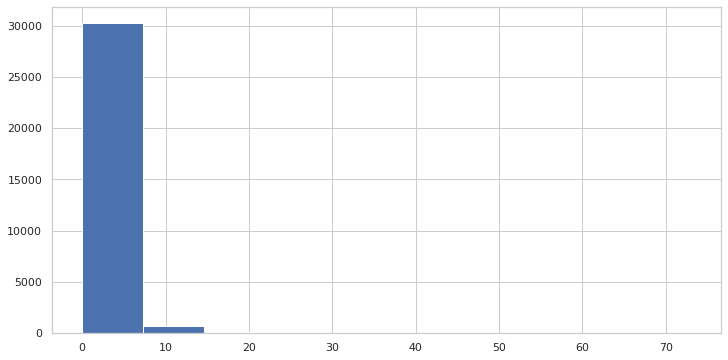

In [52]:
df.query('churn =="churn"').trips_in_first_30_days.hist()
plt.show()

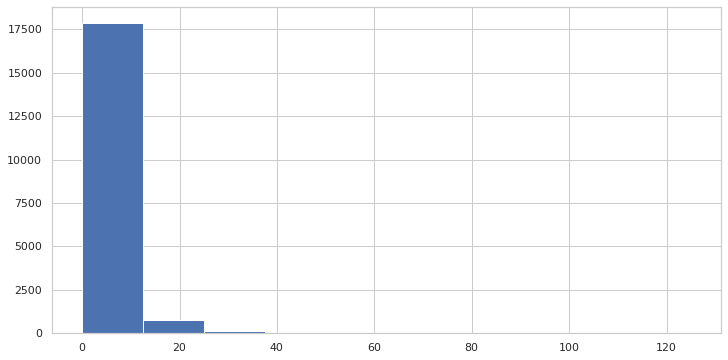

In [53]:
df.query('churn =="not_churn"').trips_in_first_30_days.hist()
plt.show()

Как мы видим, распределения не являются нормальными, потому мы используем критерий Манна-Уитни.

In [43]:
mannwhitneyu(df.query('churn =="churn"').trips_in_first_30_days,df.query('churn =="not_churn"').trips_in_first_30_days )

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

**Вывод**

Отклоняем Н0, распределение поездок в первые 30 дней у ушедших водителей и оставшимихся водителей статистически значимо различается (p<0.01). У водителей, которые продолжают пользоваться приложением, большее количество поездок в первые 30 дней пользования приложением(и по медиане, и по средней).

### churn & city & 30 days activity

Далее посмотрим, есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов

In [54]:
df.groupby('city').agg({'trips_in_first_30_days' : 'mean'})

trips_in_first_30_days
city                                  
Astapor                       1.948651
King's Landing                2.463672
Winterfell                    2.431179

In [60]:
pd.pivot_table(df[['city','trips_in_first_30_days', 'churn']], columns = 'churn', index = 'city',
               values ='trips_in_first_30_days', aggfunc ={'mean', 'median' })

mean           median          
churn              churn not_churn  churn not_churn
city                                               
Astapor         1.597838  2.969726    1.0       2.0
King's Landing  1.687550  2.923149    1.0       1.0
Winterfell      1.700589  3.776452    1.0       2.0

Видно, что по всем городам у оставшихся и ушедших есть различие в средних по поездкам в первые 30 дней. Для Астапора и Винтерфелла есть различие и в медиане

Проверяем нормальность с помощью Шапиро и графиков:

In [32]:
shapiro(df.query('city == "Astapor"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.5244418382644653, pvalue=1.401298464324817e-45)

Шапиро, p<0.01, нормальность отклоняется. Смотрим график, чтобы перепроверить

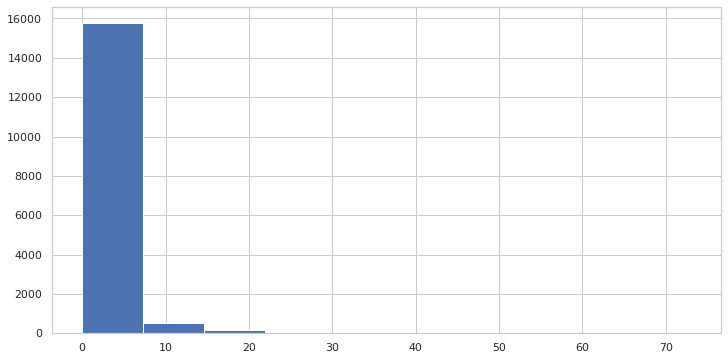

In [33]:
df.query('city == "Astapor"').trips_in_first_30_days.hist()

In [34]:
shapiro(df.query('city == "Winterfell"').trips_in_first_30_days.sample(1000))

ShapiroResult(statistic=0.620630145072937, pvalue=3.239802049518977e-42)

Шапиро, p<0.01, нормальность отклоняется. Смотрим график, чтобы перепроверить

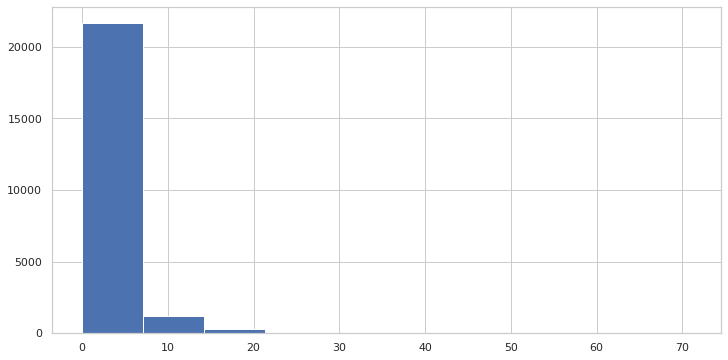

In [35]:
df.query('city == "Winterfell"').trips_in_first_30_days.hist()

Как мы видим по графикам и по Шапиро, две из трёх выборки уже не обладают нормальным распределением. Это значит, что вместо ANOVA мы должны применить его непараметрический аналог - Критерий Краскела — Уоллиса.

In [55]:
kruskal(df.query('city == "Winterfell"').trips_in_first_30_days,
        df.query('city == "Astapor"').trips_in_first_30_days,
        df.query('city != "Astapor" & city != "Winterfell"').trips_in_first_30_days
       )

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

Согласно критерию Краскела — Уоллиса, есть статистически значимые различия в распределениях поекздок в первые 30 дней по городам.
Следует уточнить, в каких именно парах они наблюдаются

In [56]:
sp.posthoc_dunn(a = df, val_col='trips_in_first_30_days', group_col='city') 

Astapor  King's Landing    Winterfell
Astapor         1.000000e+00    1.313616e-09  8.161670e-50
King's Landing  1.313616e-09    1.000000e+00  4.220106e-10
Winterfell      8.161670e-50    4.220106e-10  1.000000e+00

**Вывод**

Отклоняем Н0, распределения статистически значимо различаются(p<0.01), различия по количеству поездок в первые 30 дней у ушедших и оставшихся юзеров между городами есть, при этом между всеми парами городов.